# Motivation

At the start of the project, the group discussed many different ideas. We concluded that creating a network of video games, gathered from Steam, would be the most successfull and interesting idea for this project. There were many reasons for why we chose this solution. First, Steam has a good and intuitive API to retrieve the data. With Steam and SteamWorks API we can retrieve both the data of the games (e.g. number of active users, genres, categories...) and data to perform text analysis (e.g. descriptions and comments for each game). Secondly, we are interested in the topic and we were curious about what we would learn during the analysis. Lastly, this topic is not too common, like for example films or songs.
Unfortunately (or actually, fortunately, depends on the point of view!) it is not possible to retrieve data on specific users for privacy reasons. So, for example, it is not possible to know the list of users that play a specific game. 

The goals of the project vary. 
Firstly, we want to understand if the network has some common structure, i.e. random or scale-free. Secondly, we want to study if there are meaningful communities inside the network, based on the characteristic of the games (e.g. genres). Then, we want to perform NLP on the comments and descriptions of the games, in order to understand the sentiments for the game’s communities, as well as to find the most popular words for each community and how they differ. 



# Basic stats. Let's understand the dataset better

### Retrieve the data

Once we had agreed on the topic, we focused on retrieving the data. Unfortunately, there were some techical constraints that we had to face. The problem was about the dimension of the graph and on the time needed to retrieve all the data. In fact, there are about 105800 games on Steam, and it is only possible to make one request per second to retrieve the data of the game and not more than 200 requests in a row. So, it took more than 50 hours to only collect this data. The work was parallelized over three different computers (i.e. the maximum active sessions that Google Colab allows for a user) to overcome partially the problem of the time constraint, since the requests came from different IPs. 

At the end of the process, we managed to gather the statistics for all the games on Steam.

In the following chunks of code, only the linear process is shown, for simplicity. The process was not continuous in time with the data being saved many times in between, but those chunckes of code have been filtered out for readability. 




In [ ]:
import urllib.request
import pandas as pd
import json
import numpy as np
import networkx as nx
import time
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
steam_key = "867F8B5F0D8556E26387B363DEA1E027"
baseurl = "http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key="
format ="&format=json"

In [ ]:
#build the request for obtaining the appid and name of all the app
all_app_req = "{}{}{}".format(baseurl, steam_key,format)
print(all_app_req)

http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key=867F8B5F0D8556E26387B363DEA1E027&format=json


In [ ]:
#do the request and save the response
steamresponse = urllib.request.urlopen(all_app_req)
steamdata = steamresponse.read()
steamtext = steamdata.decode('utf-8')

In [ ]:
#save the response in a json document, then parse it to obtain the list {appid:###,name:"name"}
content = json.loads(steamtext)['applist']['apps']

In [ ]:
#all games by panda
all_games = pd.DataFrame(content)

how does this dataframe look like?

In [ ]:
all_games

appid                   name
0       1435630     Project : Skyscape
1       1435650  Spelunky 2 Soundtrack
2       1435660       Orbital Invaders
3       1435680         Poultry Parade
4       1435690          Home defender
...         ...                    ...
106018   737520  Flynn: Son of Crimson
106019   220200   Kerbal Space Program
106020  1465380    Hello From Darkness
106021  1123830      Farm Manager 2021
106022  1153060             Juicy Army

[106023 rows x 2 columns]

In [ ]:
#the API is built. Then, the request is sent to Steam and the response is stored 
responses={}
i=0
app_det_base="http://store.steampowered.com/api/appdetails/?appids=" #the only thing to add is the appid!
for appid in all_games["appid"]:
  time.sleep(1.05) #wait otherwise you will be kicked out of the server!
  steamWorksResponse = urllib.request.urlopen("{}{}".format(app_det_base, appid)) #build the API and send the request
  steamWorksData = steamWorksResponse.read() 
  steamWorksText = steamWorksData.decode('utf-8')
  responses[appid] = json.loads(steamWorksText) #save the result
  i+=1
  if i%180==0:
    with open('/content/drive/My Drive/Colab Notebooks/SG/final project/All_responses.p', 'wb') as fp: #store the results, for backup
      pickle.dump(responses, fp)
    print("waiting...")
    time.sleep(30) #wait otherwise you will be kicked out of the server!
  print(i)

At this point, there were around 106000 responses. We wanted to filter out all the responses that were not valid responses. A response is valid if the "success" field is "True", that means that the request was successfull. In addition, the response must be a "game" and not a DLC, for example. Finally, the game must have a short description and tags. 


In [ ]:
valid_responses = []

for res in responses:
  appidancora = list(responses[res].keys())
  if responses[res][appidancora[0]]['success']==True:
    data = responses[res][appidancora[0]]['data']
    if (data['type']=="game") and ("short_description" in data) and ("publishers" in data) and ("categories" in data) and ("genres" in data) and ("name" in data):
      valid_responses.append(responses[res])

In [ ]:
#retrieve the list stored during the project
with open ('/content/drive/My Drive/Colab Notebooks/SG/final project/mystuff/all_valid_responses.p', 'rb') as fp:
    valid_responses = pickle.load(fp)

In [ ]:
print("Number of valid responses: ", len(valid_responses))
print("example of one response: ", valid_responses[0:10])

Number of valid responses:  48289
example of one response:  [{'584220': {'success': True, 'data': {'type': 'game', 'name': 'RunningDead', 'steam_appid': 584220, 'required_age': 0, 'is_free': False, 'detailed_description': "Running Dead is a puzzle &amp; shot game. You will control zombies. Chase and bite the human.<br />\r\nYour little zombies will bounce back in the crowd, you can strike all of them by one shot.<br />\r\nBut it's not easy for you, because there are so many people, if you keep them too close, you'll be killed.<br />\r\n<br />\r\nFortunately, you have Dr.Dead.<br />\r\nYou can buy and active some powerful skills: some specific zombies or Infectious virus, or more powerful items.<br />\r\n<br />\r\nNow we have: <br />\r\n - 6 different zombies<br />\r\n - 13 zombie skins from achievement<br />\r\n - 9 humans(or not)<br />\r\n - 10 items in game<br />\r\n - 14 powerful ability from Dr.Dead<br />\r\n - For English and Simplified Chinese", 'about_the_game': "Running Dead is

As it can be seen from the code above, at the end there were 48289 responses. Most of the responses were DLC and not games.

### Analyse the data

As the idea was to create edges based on similarities among games, evaluated on the genres and on the categories,w e explore the distributions of these attributes of the games.

In [ ]:
num_genres=[]
num_cat=[]
genres=[]
cat=[]
for res in valid_responses: #for each game, append the statistics about the genres and categories
  appidancora = list(res.keys())
  num_genres.append(len(res[appidancora[0]]['data']['genres']))
  num_cat.append(len(res[appidancora[0]]['data']['categories']))
  for genre in res[appidancora[0]]['data']['genres']:
    genres.append(int(genre["id"]))
  for categorya in res[appidancora[0]]['data']['categories']:
    cat.append(categorya["id"])

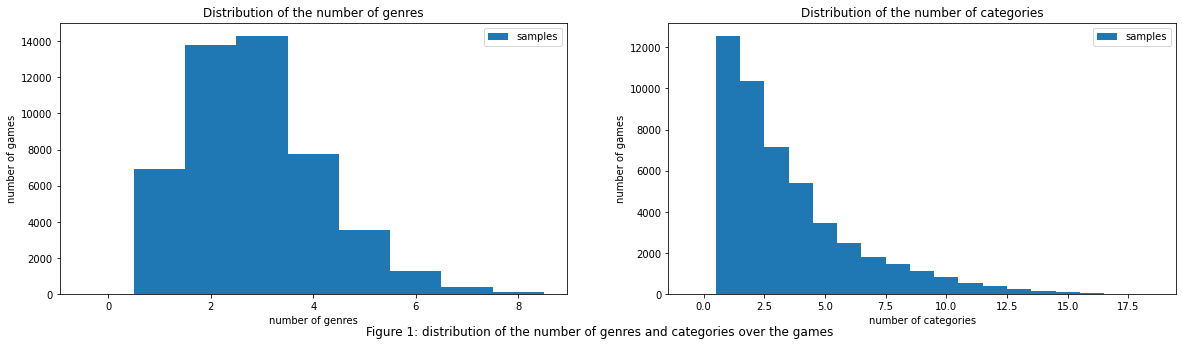

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(20, 5)) #prepare the plot

ax_flat = axarr.flatten()


_=ax_flat[0].hist(num_genres, bins=(np.arange(0,10)-0.5), label="samples") #plot the histogram
ax_flat[0].set_title("Distribution of the number of genres")
ax_flat[0].set_xlabel("number of genres")
ax_flat[0].set_ylabel("number of games")
ax_flat[0].legend()

_=ax_flat[1].hist(num_cat, bins=(np.arange(0,20)-0.5), label="samples") #plot the histogram
ax_flat[1].set_title("Distribution of the number of categories")
ax_flat[1].set_xlabel("number of categories")
ax_flat[1].set_ylabel("number of games")
ax_flat[1].legend()

_=plt.figtext(0.5, 0.01, "Figure 1: distribution of the number of genres and categories over the games", wrap=True, horizontalalignment='center', fontsize=12)


As can be seen from Figure (1), the distributions of the number of categories and the number of genres over the games differ. In particular, there is a peak when there are two and three genres whereas the peak for categories is at the beginning, and then the distribution continuously decreses. Moreover, the maximum number of genres that a game has is 8 whereas a game can have more than 15 categories. 

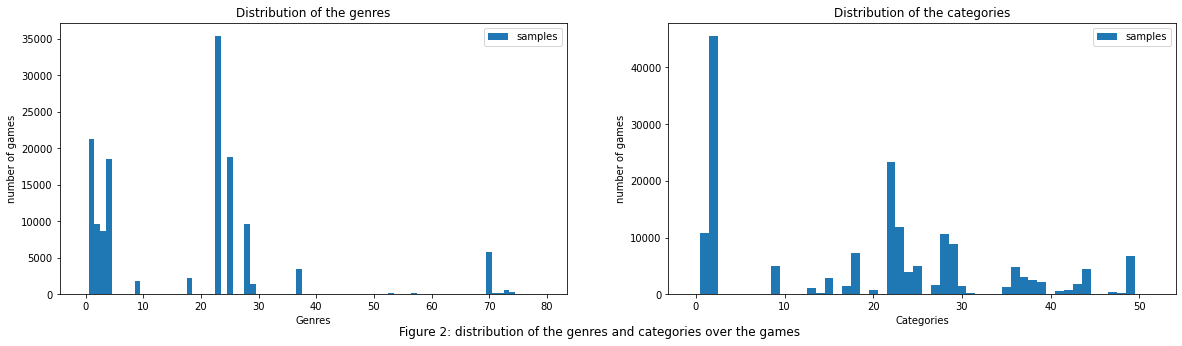

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(20, 5)) #prepare the plot

ax_flat = axarr.flatten()


_=ax_flat[0].hist(genres, bins=(np.arange(0,81)-0.5), label="samples") #plot the histogram
ax_flat[0].set_title("Distribution of the genres")
ax_flat[0].set_xlabel("Genres")
ax_flat[0].set_ylabel("number of games")
ax_flat[0].legend()

_=ax_flat[1].hist(cat, bins=(np.arange(0,53)-0.5), label="samples") #plot the histogram
ax_flat[1].set_title("Distribution of the categories")
ax_flat[1].set_xlabel("Categories")
ax_flat[1].set_ylabel("number of games")
ax_flat[1].legend()

_=plt.figtext(0.5, 0.01, "Figure 2: distribution of the genres and categories over the games", wrap=True, horizontalalignment='center', fontsize=12)

As can be seen from Figure (2), the distribution of both genres and categories over the games is not uniform. In particular, there are some genres and categories that are more frequent that the others. For example, about three fourth of the games have the genre "Indie" and almost all games have the category "Single-player". Also, there are many more categories than genres, even if the number of possible different genres is greater than the number of categories (81 against 53). (N.B. the number in the x axis is the id of the category and of the genre)

### Problems on the creation of the network

In order to create the network, we decided that the nodes would consist of games. Then, we had to decide how to create links among the games. As our goal was to find similarities among games, it was intuitive to think of ways to generate edges based on the similarities found in the tags (i.e. genres and categories). Many different options for linking the nodes were explored, for example to create an edge between two games if the number of equal tags between the two games were above a certain threshold. This method left us in trouble about how to choose this threshold proparly. We decided that doing this arbitrarily would not be the best way to link the games and went with another method.  An edge is created between two games if the similarity between them is greater than their dissimilarities. In other words, if the number of tags in common between the two games is greater than the number of tags not in common.
The process of the network creation should have been easy but, as always, the practice is different from the theory. In fact, all the attemps to build the network failed because of the big dimensions of the network itself. Working on Google Colab, after 4000 edges the system crashed, because the network had too many links. As the purpose of the project was not working on big data, it's been decided to reduce the dimension of the network in order to be able to continue the project. For this reason, it has been decided to take the 4000 most played games. It is a good choice also because after this number, there are unpopular games with few or no comments that would not have been useful in the sentiment analysis.

So insted of creating a network of all the games on Steam, we created a network of the 4000 most played games on Steam.



In [ ]:
#retrieve 5k most used with panda
most_used = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/SG/final project/5k_most_popular.csv') #the list has been retrieved from Steamspy
most_used[["position","name"]]

#merge all games and most used to obtain the 5k most used games with names and appid
id_most_used = pd.merge(most_used, all_games)
id_most_used.sort_values(by=['position'])

position                              name  ... all_time_peak   appid
0          1.0  Counter-Strike: Global Offensive  ...     1,308,963     730
1          2.0                            Dota 2  ...     1,295,114     570
2          3.0     PLAYERUNKNOWN'S BATTLEGROUNDS  ...     3,257,248  578080
3          4.0                          Among Us  ...       447,476  945360
4          5.0                Grand Theft Auto V  ...       364,548  271590
...        ...                               ...  ...           ...     ...
4163    4614.0                     All Alone: VR  ...         1,005  604830
4164    4615.0                            Pester  ...         1,004  354920
4165    4616.0                        Tribloos 2  ...         1,004  271550
4166    4620.0                            HoPiKo  ...         1,001  437390
4167    4622.0             Project First Contact  ...         1,000  634230

[4168 rows x 6 columns]

In [ ]:
#retrieve the list of valid responses of the subset stored during the project
with open ('/content/drive/My Drive/Colab Notebooks/SG/final project/valid_responses.p', 'rb') as fp:
    valid_responses = pickle.load(fp)

In [ ]:
num_genres=[]
num_cat=[]
genres=[]
cat=[]
for res in valid_responses: #for each game, append the statistics about the genres and categories
  appidancora = list(res.keys())
  num_genres.append(len(res[appidancora[0]]['data']['genres']))
  num_cat.append(len(res[appidancora[0]]['data']['categories']))
  for genre in res[appidancora[0]]['data']['genres']:
    genres.append(int(genre["id"]))
  for categorya in res[appidancora[0]]['data']['categories']:
    cat.append(categorya["id"])

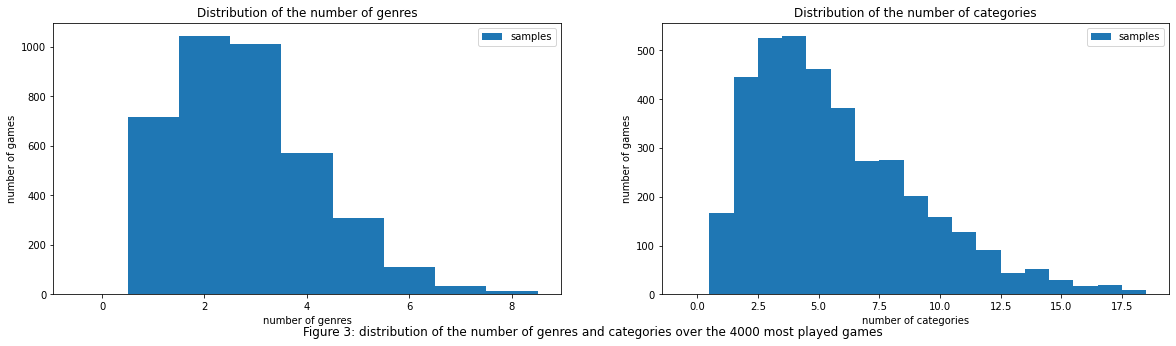

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(20, 5)) #prepare the plot

ax_flat = axarr.flatten()


_=ax_flat[0].hist(num_genres, bins=(np.arange(0,10)-0.5), label="samples") #plot the histogram
ax_flat[0].set_title("Distribution of the number of genres")
ax_flat[0].set_xlabel("number of genres")
ax_flat[0].set_ylabel("number of games")
ax_flat[0].legend()

_=ax_flat[1].hist(num_cat, bins=(np.arange(0,20)-0.5), label="samples") #plot the histogram
ax_flat[1].set_title("Distribution of the number of categories")
ax_flat[1].set_xlabel("number of categories")
ax_flat[1].set_ylabel("number of games")
ax_flat[1].legend()

_=plt.figtext(0.5, 0.01, "Figure 3: distribution of the number of genres and categories over the 4000 most played games", wrap=True, horizontalalignment='center', fontsize=12)


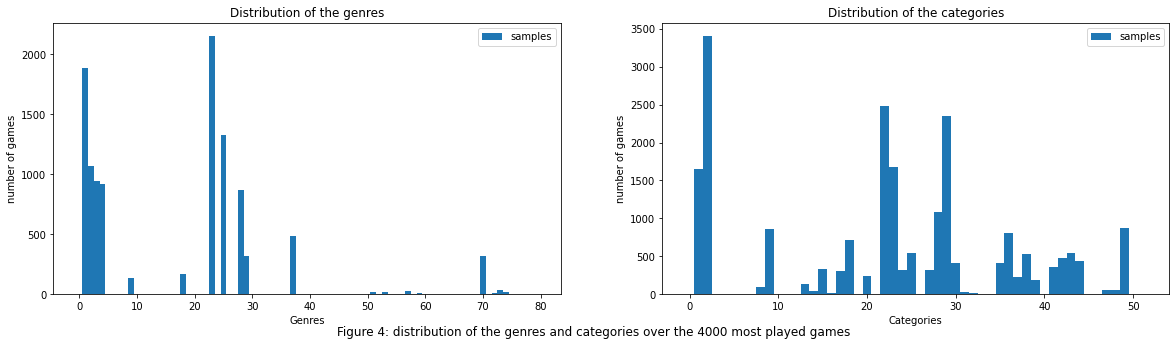

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(20, 5)) #prepare the plot

ax_flat = axarr.flatten()


_=ax_flat[0].hist(genres, bins=(np.arange(0,81)-0.5), label="samples") #plot the histogram
ax_flat[0].set_title("Distribution of the genres")
ax_flat[0].set_xlabel("Genres")
ax_flat[0].set_ylabel("number of games")
ax_flat[0].legend()

_=ax_flat[1].hist(cat, bins=(np.arange(0,53)-0.5), label="samples") #plot the histogram
ax_flat[1].set_title("Distribution of the categories")
ax_flat[1].set_xlabel("Categories")
ax_flat[1].set_ylabel("number of games")
ax_flat[1].legend()

_=plt.figtext(0.5, 0.01, "Figure 4: distribution of the genres and categories over the 4000 most played games", wrap=True, horizontalalignment='center', fontsize=12)

In Figure (3) it can be seen that the distribution of the number of categories is very similar to the previous one. On the other hand, the distribution of the number of the categories is quite different. In fact, the peak is not for 1 but it is shifted to 4. This is beacuse the attention over the tag system for popular games is greater than the attention put by the average games, and for this reason the average number of categories per game is higher.

Figure (4) shows the distribution of the tags. As before, there are some tags that are present in almost each game, for example the category "Single-player" and the genre "Indie", as before.

As the distributions are similar to those obtained with the complete set of games, it can be assumed that the subset is a good reduced version of the original set, in terms of topologic properties.

### Network creation

In [ ]:
#retrieve the list stored during the project
with open ('/content/drive/My Drive/Colab Notebooks/SG/final project/valid_responses.p', 'rb') as fp:
    valid_responses = pickle.load(fp)

In [ ]:
#create the network object
gamesNet = nx.Graph()

Add all the nodes, saving the properties as attributes 

In [ ]:
#add the nodes. See the example of the response above for the structure of the response
for res in valid_responses:
  fields = list(res.keys()) #return the fields of the json object
  data = res[fields[0]]['data']  #take the data
  #create the node with all the fields needed
  gamesNet.add_node(fields[0], name = data["name"], short_description = data["short_description"], publishers=data["publishers"], tags=[cat["description"] for cat in data["categories"]]+[cat["description"] for cat in data["genres"]])

In [ ]:
print("Number of nodes: ",len(gamesNet.nodes()))
print("Example of the structure of one node of the network: ")
gamesNet.nodes()["730"]

Number of nodes:  3813
Example of the structure of one node of the network: 


{'name': 'Counter-Strike: Global Offensive',
 'publishers': ['Valve'],
 'short_description': 'Counter-Strike: Global Offensive (CS: GO) expands upon the team-based action gameplay that it pioneered when it was launched 19 years ago. CS: GO features new maps, characters, weapons, and game modes, and delivers updated versions of the classic CS content (de_dust2, etc.).',
 'tags': ['Multi-player',
  'Steam Achievements',
  'Full controller support',
  'Steam Trading Cards',
  'Steam Workshop',
  'In-App Purchases',
  'Valve Anti-Cheat enabled',
  'Stats',
  'Remote Play on Phone',
  'Remote Play on Tablet',
  'Remote Play on TV',
  'Action',
  'Free to Play']}

In [ ]:
#retrieve the tags in order to create the links
tags=nx.get_node_attributes(gamesNet,'tags')

Create the edges, comparing the tags of the nodes

In [ ]:
for from_node in gamesNet.nodes(): #for each...
  for to_node in gamesNet.nodes(): #...pair of...
    if from_node != to_node:       #...different nodes
      from_set_tags = set(tags[from_node]) 
      to_set_tags = set(tags[to_node]) 
      #if the intersection of the tags (common tags) is bigger than the symetric difference of the tags (tags not in common)
      if len(from_set_tags.intersection(to_set_tags)) > len(from_set_tags.symmetric_difference(to_set_tags)): 
        gamesNet.add_edge(from_node, to_node, common_tags=list(from_set_tags.intersection(to_set_tags))) #create a link, saving the common tags

In [ ]:
print("Number of edges: ", gamesNet.size())
print("Example of the structure of one link of the network: ")
print(gamesNet.edges()["730","440"])

Number of edges:  383955
Example of the structure of one link of the network: 
{'common_tags': ['Stats', 'Steam Trading Cards', 'Valve Anti-Cheat enabled', 'Free to Play', 'Steam Achievements', 'In-App Purchases', 'Steam Workshop', 'Multi-player', 'Remote Play on Tablet', 'Action', 'Remote Play on Phone']}


As we wanted to work on a connected components, the biggest connected components was extracted.

In [ ]:
#extract and copy the biggest connected component
Gcc = sorted(nx.connected_components(gamesNet), key=len, reverse=True)
gamesNetConnected = gamesNet.subgraph(Gcc[0])

In [ ]:
N=len(gamesNetConnected)
L=gamesNetConnected.size()
print("Number of nodes of the biggest connected component: ",N)
print("Number of edges of the biggest connected component: ", L)
print("Probability of a link between two nodes: ",L/(N*(N-1)/2))

Number of nodes of the biggest connected component:  3773
Number of edges of the biggest connected component:  383943
Probability of a link between two nodes:  0.05395581543134944


In [ ]:
nx.write_gml(gamesNetConnected, "/content/drive/My Drive/Colab Notebooks/SG/final project/finalNet.gml")

As can be seen from the results above, the biggest connected component contains most of the nodes (3773 out of 3813). The games excluded were the last games of the list, played by only few gamers and with very specific tags. The probability of having a link between two edges is around 5.4 %. The notion of density is not easy to apply but it can be said that this network is not dense. 

# Tools, theory and analysis. Describe the process of theory to insight
### Analysis step 1: Visualisation of the network

  - **explain what you're interested in:** To start working with the network, it is interesting to visualize it.
  - **explain the tool:** to visualise the network, the positions of the nodes are computed with the method `forceatlas2.forceatlas2_networkx_layout` that, given the parameters with which to calculate the positions, returns a dictionary in which the keys are the nodes and the values the related positions. Then, `draw_networkx_nodes` and `draw_networkx_edges` are used to actually draw the graph, giving to the method also the size of each node, proportional to its degree. 
  - **apply the tool:** 



In [ ]:
from fa2 import ForceAtlas2  #the package should be installed before

In [ ]:
GN = nx.read_gml('/content/drive/My Drive/Colab Notebooks/SG/final project/finalNet.gml')

In [ ]:
node_size_map = []  #structure to save the list of the sizes for the nodes

for node in GN:  #for each node of the network...
    node_size_map.append(GN.degree(node)/8)   #set the size proportionally to its degree

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.2,

                        # Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=True,
                        gravity=1.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GN, pos=None, iterations=1000)  #prepare the visualisation: set the positions of the nodes

100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]

BarnesHut Approximation  took  24.14  seconds
Repulsion forces  took  70.31  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  18.82  seconds
AdjustSpeedAndApplyForces step  took  1.04  seconds


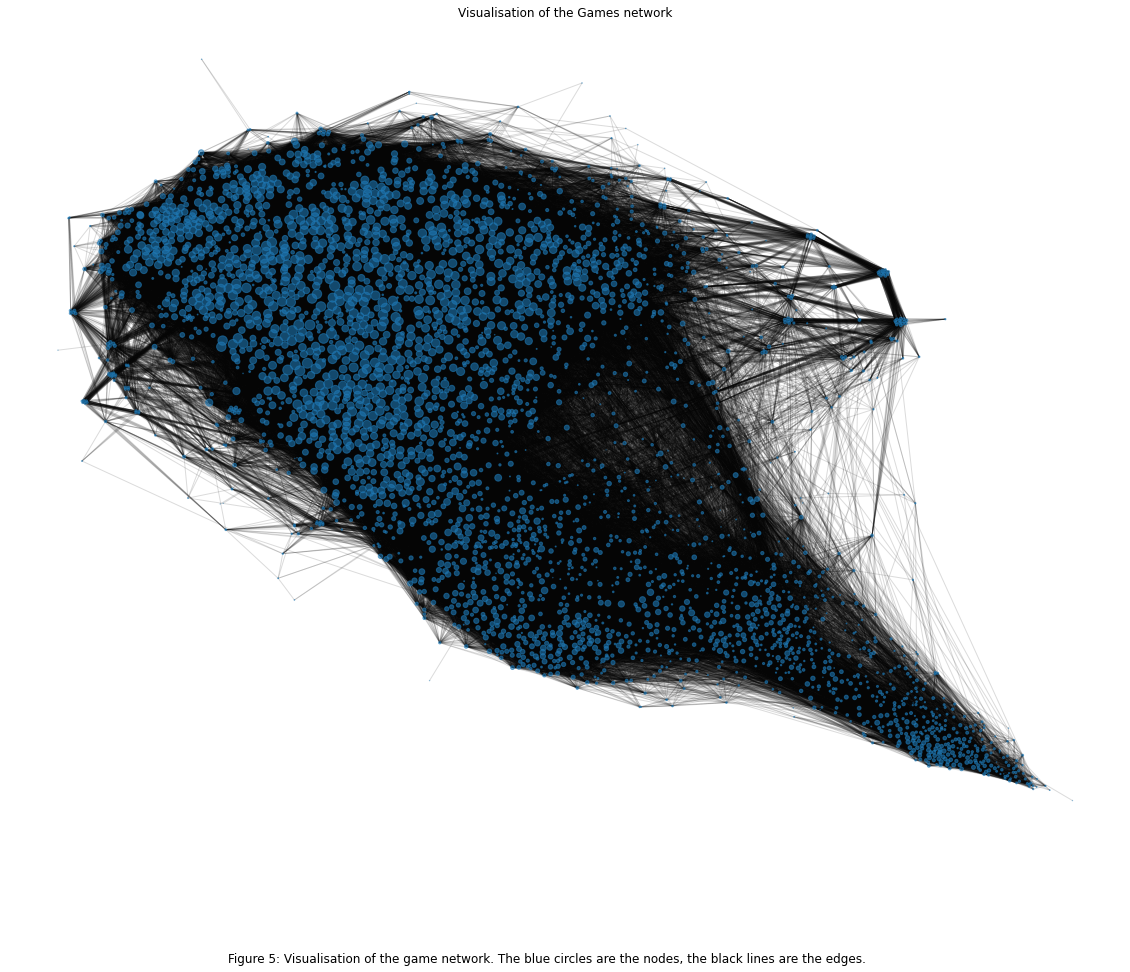

In [ ]:
plt.figure(figsize=(20,15))  #set the figure
plt.title("Visualisation of the Games network")
plt.axis('off')
nx.draw_networkx_nodes(GN, positions, node_size=node_size_map, alpha=0.6)#, node_color=color_map)
nx.draw_networkx_edges(GN, positions, alpha=0.14)#, edge_color=edge_map)
_=plt.figtext(0.5, 0.01, "Figure 5: Visualisation of the game network. The blue circles are the nodes, the black lines are the edges.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

  - **discuss the outcome:** Figure (5) shows the games graph. In particular, the nodes are the blue circles and the edges are the black lines. It can be seen that some of the nodes are bigger than the others, because their degree is higher.

## General analysis of the topology
To start the analysis of the network, we wanted to study its topology, in order to understand better what we were working with. To do that, we analysed the degree distribution as well as other general properties as the average length and the average global clustering coefficient. At the end, we discovered that the properties of this network are really strange, as they don't follow none of the predictions done at each step. This confused us a lot and we think that the knowledges provided during the course are not enough to understand deeply the topology of the graph.

### Analysis step 2: Degree distribution
  - **explain what you're interested in:** First of all, we are interested in analyse the degree distribution of the network in order to understand, for example, whether it is a random or a scale-free network.
  - **explain the tool:** in order to inpsect the degree distribution, we use the method `network.degree()`, that returns a dictionary in which the keys are the nodes and the values are the corresponding degree. From that, it is easy to extract the values and create an histogram to print in both linear and logarithmic versions.
  - **apply the tool:** 

In [ ]:
degree_sequence = [d for n, d in GN.degree()]

hist, bin_edges = np.histogram(degree_sequence, bins=100)

f, axarr = plt.subplots(1, 2, figsize=(20, 5))

ax_flat = axarr.flatten()

ax_flat[0].scatter(bin_edges[:-1], hist, s = 15, label = "samples")
ax_flat[0].set_title("Degree distribution in a linear plot")
ax_flat[0].set_xlabel("Degree")
ax_flat[0].set_ylabel("Number of nodes")
ax_flat[0].grid()
ax_flat[0].legend()

ax_flat[1].scatter(bin_edges[:-1], hist, s = 15, label = "samples")
ax_flat[1].set_title("Degree distribution in a log-log plot")
ax_flat[1].set_xlabel("Degree")
ax_flat[1].set_ylabel("Number of nodes")
ax_flat[1].grid()
ax_flat[1].set_yscale("log")
ax_flat[1].set_xscale("log")
ax_flat[1].set_ylim(1,1000)
ax_flat[1].legend()

_=plt.figtext(0.5, 0.01, "Figure 6: Degree distribution", wrap=True, horizontalalignment='center', fontsize=12)

  - **discuss the outcome:** Figure (6) shows the degree distribution of the network in both linear and log-log scale. It can be seen that the distribution is neither a random distribution nor a scale-free. The linear plot, qualitatively, looks like a distribution of a scale-free network. In fact there are a lot of nodes with a low degree and then the frequency decreases as the degree increases. Finally, there are also some nodes with a really high degree, the hubs, predicted by a scale-free network. On the other hand, in the log-log plot is clearly visible that the distribution is not the one of a scale-free network. In fact, the points are not in a straight line but are arrenged as for a random network.

### Analysis step 3: Scale-free alpha
  - **explain what you're interested in:** as the distribution is ambiguous, we want to analyse it better fitting it with a power law and check the exponent of the function. 
  - **explain the tool:** in order to fit the data with a power law, we use the method `powerlaw.Fit()` and then we check the alpha parameter inspecting the object `power_law.alpha`.
  - **apply the tool:** 

In [ ]:
!pip install powerlaw #in order to install the package, if not installed yet

In [ ]:
import powerlaw  #import the package

In [ ]:
g_deg = powerlaw.Fit(degree_sequence, verbose = False).power_law.alpha
print("Gamma of degree: ", g_deg)

Gamma of degree:  17.607723484344884


  - **discuss the outcome:** in Section (4.7) of the Network Science book by Albert-Lázló Barabási (http://networksciencebook.com/chapter/4#degree-exponent) there is a good explanation of what it is happening. In fact when $\gamma>3$ we are in the random network regime. "For all practical purposes the properties of a scale-free network in this regime are difficult to distinguish from the properties of a random network of similar size". For this reason, our network is not a random network but it doesn't have neither the distribution of a scale-free network. In general, we can say that our network belongs to the class of the Fat Tailed Networks. 

### Analysis step 4: Average path length
  - **explain what you're interested in:** as the tolopogy of the network is still ambiguous, we want to analyse it better looking at the average path length. In fact, the formula (4.22) in Section (4.6)  of the Network Science book by Albert-Lázló Barabási (http://networksciencebook.com/chapter/4#ultra-small) predicts the dependence of the average distance $<d>$ on the system size N and the degree exponent $\gamma$. For random network and for networks with $\gamma$ greater than 3, $<d>$ should grow following $ln(N)$ whereas for networks with $2< \gamma < 3$ it should grow proportional to $\frac{lnN}{lnlnN}$. In this case, we don't have different graphs to analyse the behaviour, but we can analyse the punctual average length.
  - **explain the tool:** to compute the average length, `nx.average_shortest_path_length(G)` is used.
  - **apply the tool:** 

In [ ]:
N=len(GN.nodes())

In [ ]:
d = nx.average_shortest_path_length(GN)
print("Average path experimentally: ", d)
print("Average path mathematically (small world): ", np.log(N))
print("Average path mathematically (ultra-small world): ", np.log(np.log(N)))

Average path experimentally:  2.715807943868627
Average path mathematically (small world):  8.235625719964311
Average path mathematically (ultra-small world):  2.108469343738101


  - **discuss the outcome:** it's true that the formula predict only the behaviour of the average path and not the punctual value. Nevertheless, it is pretty clear that the experimental value is much more similar to the ultra-small world than the small world. This means that this property follows that of a scale-free network, even if $\gamma$ is greater than 3.

### Analysis step 5: Average global Clustering coefficient
  - **explain what you're interested in:** as last experiment on the network topology, we wanted to analyse the clustering coefficient. In Section (5.10)  of the Network Science book by Albert-Lázló Barabási (http://networksciencebook.com/chapter/5#diameter) the formula (5.30) predicts the dependence of the average clustering coefficient $<C>$ for a random and for a scale-free network.In a random network, $<C>$ should be proportional to 1/N whereas for a scale-free network, it should be proportional to $(lnN)^2/N$. As for the case before, we don't have different graphs to analyse the behaviour, but we can analyse the punctual results.
  - **explain the tool:** to compute the average clustering coefficient, `nx.average_clustering(G)` is used.
  - **apply the tool:** 

In [ ]:
C = nx.average_clustering(GN)
print("Clustering coefficient experimentally: ", C)
print("Clustering coefficient mathematically (scale-free): ",np.power(np.log(N),2)/N)
print("Clustering coefficient mathematically (random): ", 1/N )

Clustering coefficient experimentally:  0.46711667176059984
Clustering coefficient mathematically (scale-free):  0.017976552080396946
Clustering coefficient mathematically (random):  0.00026504108136761196


  - **discuss the outcome:** as before, the formula predict only the behaviour of the average clustering and not the punctual value. Nevertheless, it is pretty clear that the experimental value is much more similar to the value predicted for a scale-free network than the random one. This means that this property follows that of a scale-free network, even if $\gamma$ is greater than 3. In addition, it must be said that the experimental value is very different from both the predictions, so this property doesn't explain very much about the topology of the network.

## Communities

In this section of the analysis, the communities are the protagonists. First of all, we will create them and we will visualise them. Then, some statistics are computed in order to understand better their properties. In particular we wil study the goodness of the partition, both qualitatively (e.g. inspecting the communities, the number of nodes, the most common tags...) and quantitatively (e.g. degree distribution, correlation matrix, modularity...).

### Analysis step 6: creation of the communities
  - **explain what you're interested in:** in this first step, we were interested in create the communities in order to make further analysis on them.
  - **explain the tool:** The Louvain Algrithm is used to uncover communities in large networks. The method consists of two phases. First, it looks for "small" communities by optimizing modularity in a local way. Second, it aggregates nodes of the same community and builds a new network whose nodes are the communities. These steps are repeated iteratively until a maximum of modularity is attained. The output of the program therefore gives several partitions. The partition found after the first step typically consists of many communities of small sizes. At subsequent steps, larger and larger communities are found due to the aggregation mechanism. This process naturally leads to hierarchical decomposition of the network. This is an approximate method and nothing ensures that the global maximum of modularity is attained, but several tests have confirmed that the algorithm has an excellent accuracy and often provides a decomposition in communities that has a modularity that is close to optimality. (https://sites.google.com/site/findcommunities/)
  - **apply the tool:** 

In [ ]:
import community as cmg #the package should be installed before
from collections import Counter 
import collections
import pickle
import operator

In [ ]:
#Louvain method
partition = cmg.best_partition(GN, random_state= 10) #random state in order to obtain always the same result
#The optimal modularity reached with the Louvain method
M = cmg.modularity(partition, GN)
print("Optimal Modularity: ", M)

Optimal Modularity:  0.4299667319417017


Number of communities found: 6


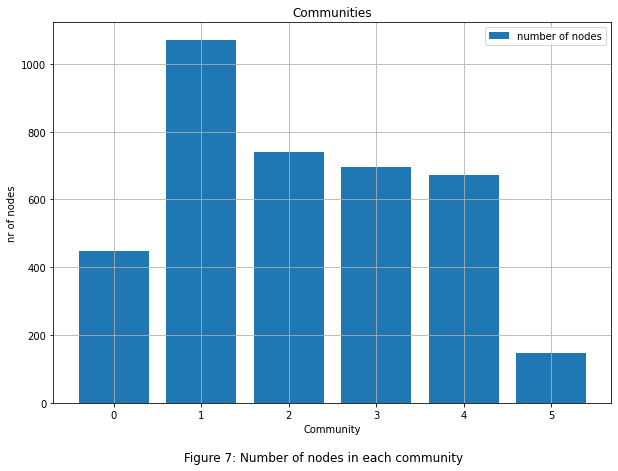

In [ ]:
#Get a dictonary of which character(node) belongs to which community
data = partition.values()
# creating a list with the keys 
items = Counter(data).keys() 
print("Number of communities found:", len(items))
#count the number of characters within each community
c = collections.Counter(data)
c = sorted(c.items())
#Get nr of community
nr = [i[0] for i in c]
#Get nr of characters in each community
freq = [i[1] for i in c]

#Plot the distribution, setting all the plt properties
plt.figure(figsize=(10,7))  #set the figure
plt.bar(nr, freq, label="number of nodes")
plt.title("Communities")
plt.xlabel("Community")
plt.ylabel("nr of nodes")
plt.legend()
plt.grid()
_=plt.figtext(0.5, 0.01, "Figure 7: Number of nodes in each community", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

  - **discuss the outcome:** It can be seen that the score of the modularity is around 0.5, in a range between -1 and +1. This means that there is an high level of modularity, and so the communities are well defined. This is a good news as we wanted to find meaningful communities for the further analysis. In Figure (7) it can be seen that there are siz communities. In particular there are three communities with quite the same number of nodes (around 700). Then, there are two communities with respectively around 300 nodes more and less. Finally, there is one community with less than 200 nodes.

### Analysis step 7: visualisation of the communitites
  - **explain what you're interested in:** to start working with the communities, it is interesting to visualise them.
  - **explain the tool:** the process to visualise the communities is the same of that for the whole graph. In this case, in addition, nodes are coloured with respect to the community they belong to. This is done with the `node_color` parameter, that takes as input the list of the color to assign at the nodes. 
  - **apply the tool:** 

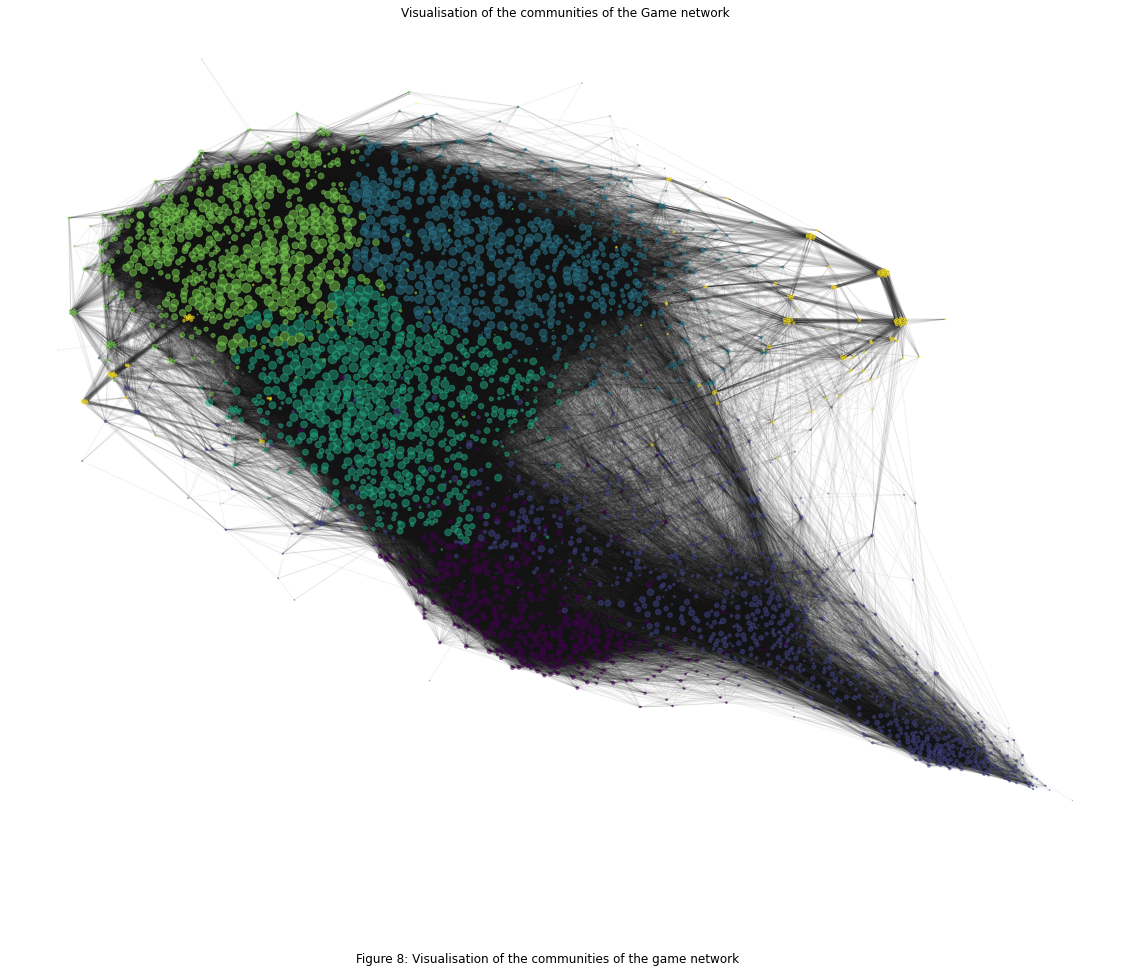

In [ ]:
color_map = []  #structure to save the list of the colors for the nodes
edge_map = []  #structure to save the list of the colors for the nodes

plt.figure(figsize=(20,15))  #set the figure

color_map = list(partition.values())
for link in GN.edges():
  edge_map.append(partition[link[0]]*partition[link[1]]+partition[link[0]]+6)

nx.draw_networkx_nodes(GN, positions, node_size = node_size_map, node_color=color_map, alpha=0.5)
nx.draw_networkx_edges(GN, positions, alpha=0.05)

plt.axis('off')
plt.title("Visualisation of the communities of the Game network")
_=plt.figtext(0.5, 0.01, "Figure 8: Visualisation of the communities of the game network", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

  - **discuss the outcome:** It can be seen from the figure above that the communities are well separated. This was predictable as the forceatlas algorithm arranges the nodes to minimize the crossing among edges, and this leads to organize the nodes by communities. In particular, it is easy to find the three communities with the same number of nodes on the top left corner, the smallest community on the top right corner of the graph, the biggest on the bottom and the second smallest in the bottom left corner. The same-dimension three communities contain the biggest nodes, those with the highest degree. The smallest community contains agglomerates of nodes, that are small nodes (i.e. low degree) but really connected one to each other.

  ### Analysis step 8: give a name to the communities
  - **explain what you're interested in:** in order to not continue to refer to the communities by their dimension, it is nicer to give them a name. As the main point of the communities are the tags, they will be used.
  - **explain the tool:** the following code is explained step by step and it is easier to understand it reading the comments, instead of writing all the steps here. The genral idea is that we want to identify each community with its most three common tags, that are the tags that appear most frequently for the nodes of that community. In this way, it will be easier to identify them and in the same time we will have the opportunity to understand better how the nodes are grouped. The main idea is to get the list of nodes for each community by the `partition` dictionary created before. Then, we will inspect each node of the community counting how many times each tag appears in that community. Finally, each community is visualised.    
  - **apply the tool:** 

In [ ]:
#in partition dictionary, the keys are the nodes and the values the relative community
#we want to have a dictionary in which the keys are the communities amd the values are the list of the nodes in those communities
#there are many ways to do that, the following is maybe the most readable
communities_by_value={} 
for key in partition:
  if partition[key] in communities_by_value:
    communities_by_value[partition[key]].append(key)
  else:
    communities_by_value[partition[key]]=[key]

In [ ]:
#Now that we have the list of the nodes for each community, we can find the most common tags for each of them
names = {} #to store the names of each community
labels = {}  #to set a label for each community, for the visualisation

tags_for_game = nx.get_node_attributes(GN, "tags") #it returns a dictionary in which the keys are the names and the values are the list of the string of the attribute "tags"
for i in range(len(communities_by_value)): #for each community
  tags_for_comm = [""] #object to save the list of tags for that community, it needs at least one element for "extend" method
  count = 0
  for game in GN.nodes(): #for each game
    if partition[game]==i: #if it belongs to the partition into exam
      count+=1
      tags_for_comm.extend(tags_for_game[game])
      if count == 90:
        label=game  #only for one node, save its name to assign it a label for the final visualisation
  #count the occurancies of each tag, without considering some really common and not informative tags
  words_to_count = (word for word in tags_for_comm if word not in ["Steam Cloud","Steam Achievements","Steam Trading Cards","Single-player","Multi-player"]) 
  c = Counter(words_to_count)
  print("Community: ",i)
  print("Number of nodes in the community: ",count)
  print("Three most common tags: ",c.most_common(3))
  names[i]=[value[0] for value in c.most_common(3)] #save the list of the three most common tags 
  labels[label]=names[i] #assign a label at one node of the community

  #find the most popular games for the community
  comm_sub = GN.subgraph(communities_by_value[i])
  degree = dict(comm_sub.degree()) #return the dictionary of degrees
  print("Most connected game: ", GN.nodes()[max(degree.items(), key=operator.itemgetter(1))[0]]["name"])
  print()

Community:  0
Number of nodes in the community:  448
Three most common tags:  [('Remote Play Together', 405), ('Shared/Split Screen', 311), ('Full controller support', 296)]
Most connected game:  Just Shapes & Beats

Community:  1
Number of nodes in the community:  1069
Three most common tags:  [('Action', 669), ('Online PvP', 628), ('PvP', 619)]
Most connected game:  Necromunda: Underhive Wars

Community:  2
Number of nodes in the community:  740
Three most common tags:  [('Indie', 579), ('Strategy', 429), ('Casual', 370)]
Most connected game:  Train Valley

Community:  3
Number of nodes in the community:  697
Three most common tags:  [('Full controller support', 515), ('Action', 403), ('Adventure', 387)]
Most connected game:  Hellblade: Senua's Sacrifice

Community:  4
Number of nodes in the community:  673
Three most common tags:  [('Indie', 582), ('Adventure', 416), ('Action', 407)]
Most connected game:  Inner silence

Community:  5
Number of nodes in the community:  146
Three most

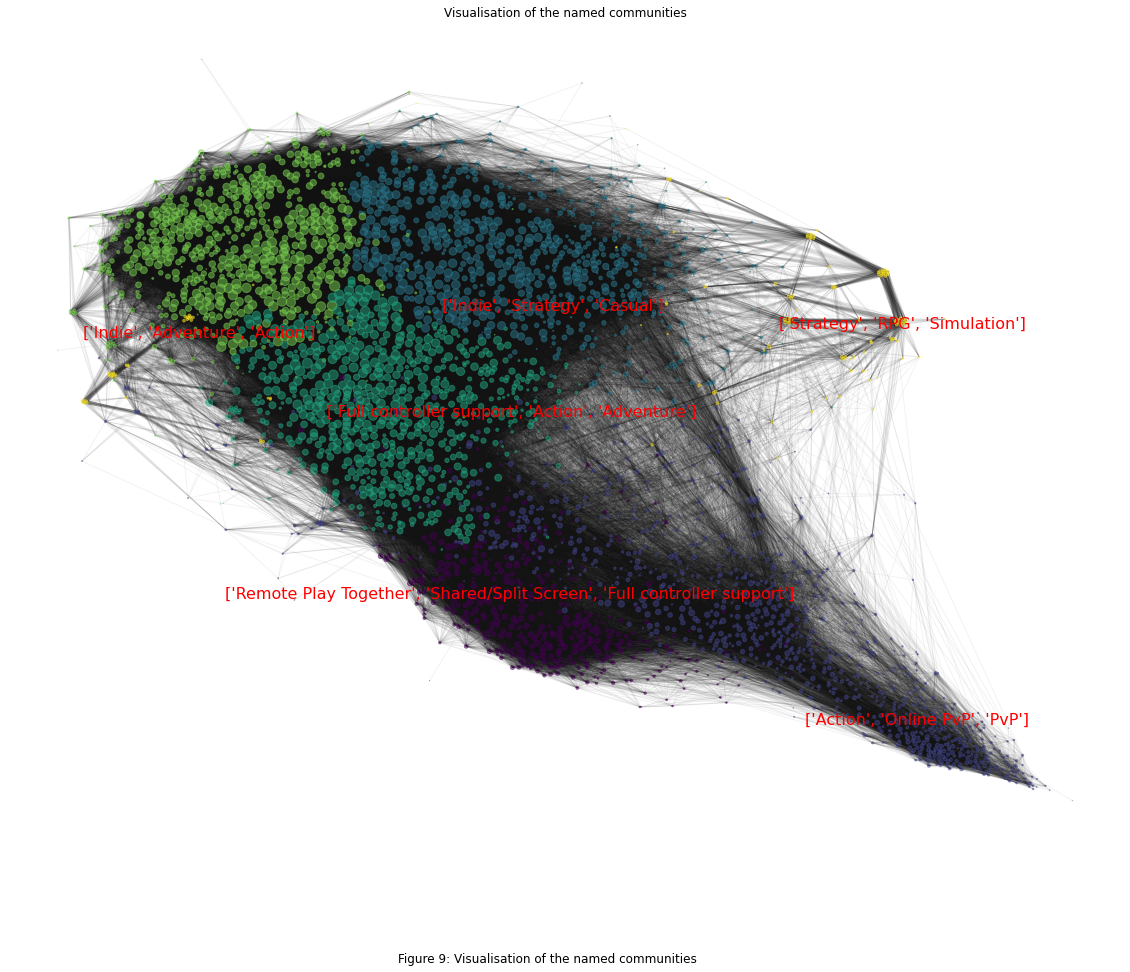

In [ ]:
plt.figure(figsize=(20,15))  #set the figure

nx.draw_networkx_nodes(GN, positions, node_size = node_size_map, node_color=color_map, alpha=0.5)
nx.draw_networkx_edges(GN, positions, alpha=0.05)
nx.draw_networkx_labels(GN, positions, labels, font_size=16, font_color='r')

plt.axis('off')
plt.title("Visualisation of the named communities")
_=plt.figtext(0.5, 0.01, "Figure 9: Visualisation of the named communities", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


  - **discuss the outcome:** Figure (9) shows the communities of the network with their names. It can be seen that each community is identified by a different triplet of tags. This mean that each community has, in fact, games with different tags and so the partition is meaningful with respect to the tags. Outline of each community:
    - [Remote Play Together, Shared/Split ScreenFull, controllor support]: This community has 448 nodes. So it is the second smallest one. The most common tags are "Remote Play Together" (405 games have this tag), "Shared/Split Screen" (311 have) and "Full controllor support" (296). So, more or less all the games of this community are online games in which you can share the screen. The most connected game is "Just Shapes & Beats".

    - [Action, Online PvP, PvP]: This community has 1069 nodes and it is the biggest one. The most common tags are "Action" (669 games have this tag), "Online PvP" (628 have) and "PvP" (619). So, in this community there are the games action and Player Versus Player, both online and offline. These are the most popular games at the moment, as "Counter Strike". The most connected game is "Necromunda: Underhive Wars".

    - [Indie, Strategy, Casual]: In this community there are 740 nodes. The most common tags are "Indie" (579 games have this tag), "Strategy" (429 have) and "Casual" (370). The games in this community are mainly strategy games in an old and simple style. The most connected game is "Train Valley".

    - [Action, Adventure, Full controller support]: In this community there are 697 nodes. The most common tags are "Action" (403 games have this tag), "Adventure" (387 have) and "Full controller support" (515). We can understand that the games in this community are games that can be played even without a keyboard (so with controllers) and are adventurous. The most connected game is "Hellblade: Senua's Sacrifice".

    - [Indie, Adventure, Action]: In this community there are 673 nodes. The most common tags are "Indie" (582 games have this tag), "Adventure" (416 have) and "Action" (407). The games in this community are similar to the games of the previous one, with the difference that these games are created by individuals or smaller development teams. The most connected game is "Inner silence".

    - [Strategy, RPG, Simulation]: In this community there are 147 nodes. This is the smallest community and the tags are very different from the other communities. The most common tags are "Strategy" (96 games have this tag), "RPG" (47 have) and "Simulation" (23). So, the games of this community are mainly strategic role-play/simulation games. The most connected game is "Supreme Commander: Forged Alliance".

  ### Analysis step 9: degree distribution for the communities
  - **explain what you're interested in:** as done for the whole network, it is interesting to analyse the degree distributions of each community, to see if there are differences between the distributions of the subgraphs and the complete netweork.
  - **explain the tool:** as for the case before, we use the method `network.degree()` that returns a dictionary in which the keys are the nodes and the values are the corresponding degree. From that, it is easy to extract the values and create an histogram to print in both linear and logarithmic versions. This is repeated for each community.
  - **apply the tool:**

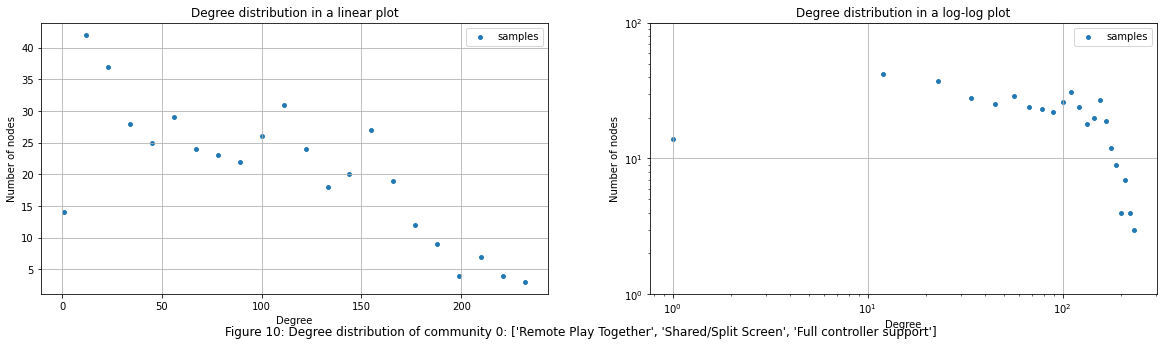

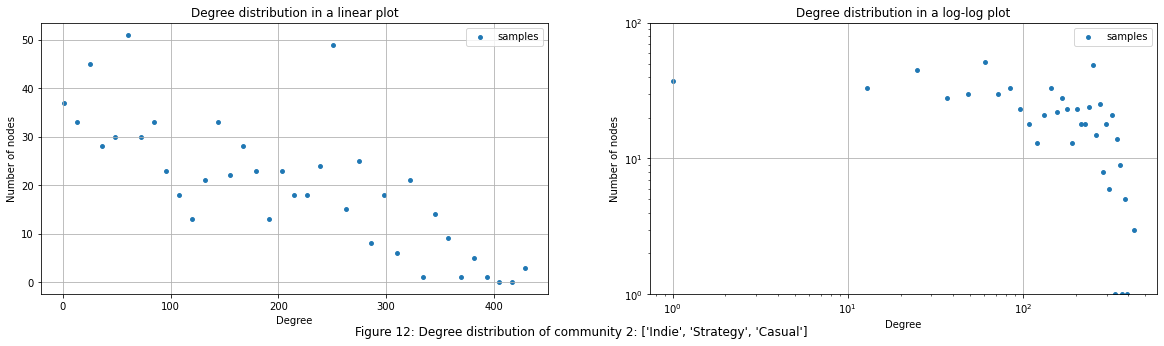

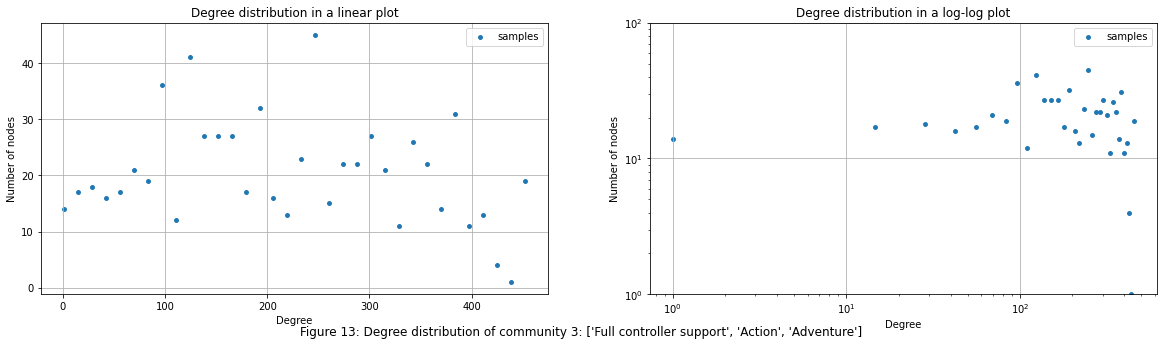

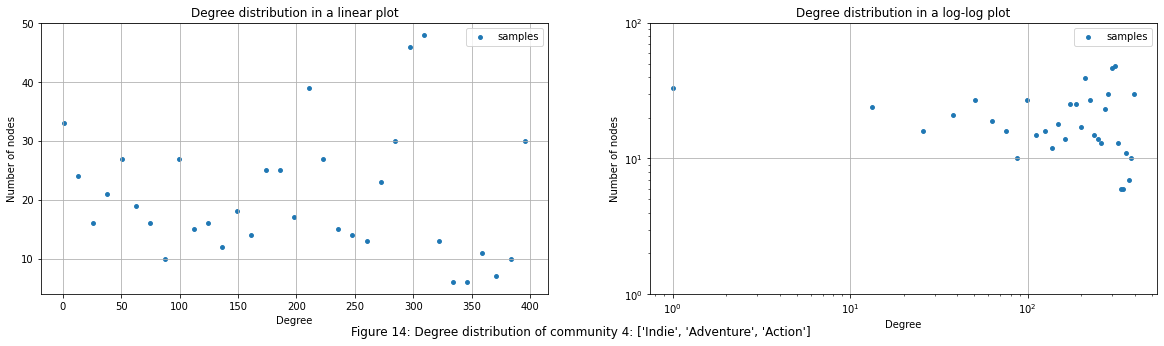

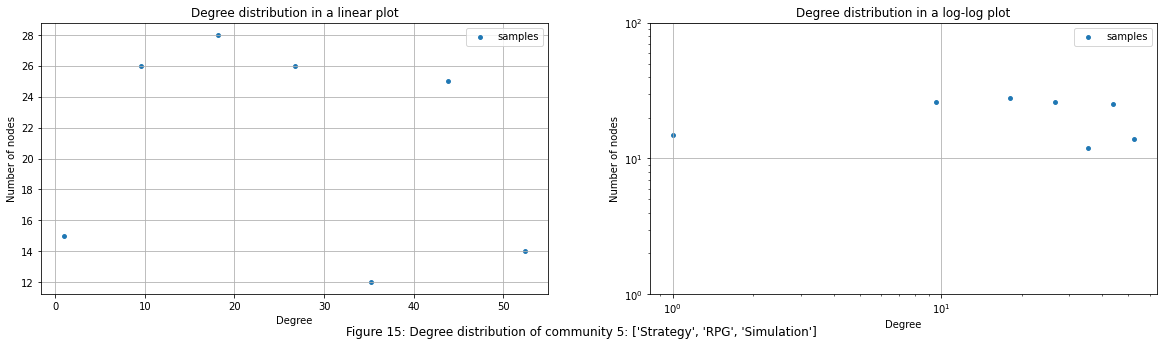

In [ ]:
for i in communities_by_value: #for each community
  f, axarr = plt.subplots(1, 2, figsize=(20, 5)) #set the plot
  ax_flat = axarr.flatten()

  plt.title(names[i])
  k = GN.subgraph(communities_by_value[i]) #extract the community subgraph
  degree_sequence = [d for n, d in k.degree()] #find the degree
  hist, bin_edges = np.histogram(degree_sequence, bins=(len(k.nodes())//20)) #create the histogram

  ax_flat[0].scatter(bin_edges[:-1], hist, s = 15, label = "samples") #plot the histogram
  ax_flat[0].set_title("Degree distribution in a linear plot")
  ax_flat[0].set_xlabel("Degree")
  ax_flat[0].set_ylabel("Number of nodes")
  ax_flat[0].grid()
  ax_flat[0].legend()

  ax_flat[1].scatter(bin_edges[:-1], hist, s = 15, label = "samples") #plot the histogram
  ax_flat[1].set_title("Degree distribution in a log-log plot")
  ax_flat[1].set_xlabel("Degree")
  ax_flat[1].set_ylabel("Number of nodes")
  ax_flat[1].grid()
  ax_flat[1].set_yscale("log")
  ax_flat[1].set_xscale("log")
  ax_flat[1].set_ylim(1,100)
  ax_flat[1].legend()

  _=plt.figtext(0.5, 0.01, "Figure "+str(10+i)+": Degree distribution of community "+str(i)+": "+str(names[i]), wrap=True, horizontalalignment='center', fontsize=12)
  plt.show()

  - **discuss the outcome:** from Figure (10) to Figure (15) above, the linear and log-log distributions for each community are shown. The first three figures are pretty clear and it is visible that the distributions are really similar to those of the whole network. In fact, the linear distribtuion is a descending line, that it is neither the distribution of a random not that of a free-scale distribution. It can be seen that they are not free-scale distributions also from the relative log-log plot, that are not straight lines. As for the whole network, the distributions don't explain the topology very well. The last three images are even more confused, with the distributions that don't follow any rules in the linear plot. It is visible that the log-log plots are aranged similar to the first three, so it is plausible to assume that they indeed have a similar distribution. As a conclusion, we have discovered that the distributions of the communities are similar to that of the whole network, and as that one is difficult to find a meaning, as the properties are neither of a random nor of a scale-free network.

  ### Analysis step 10: intercorrelations among communities
  - **explain what you're interested in:** in order to analyse deepler the communities, an interesting aspect to study is the intercorrelations among the communities. This should be encoded in the modularity parameter, that is a measure of the goodness of the partition, that tends to group together nodes that are high correlated and put in different groups nodes that are low correlated. For this reason, we should expect that there are many links between each community and few links among different communities.  
  - **explain the tool:** in this case, it is enough to parse each edge of the network and increase the counter of the respective cell in a correlation matrix. The cell$_{ij}$ is incremented by one if the edge is between the node $i$ and the node $j$. As the graph is undirected, the link from $i$ to $j$ is the same as the link from $j$ to $i$. For this reason, both $c_{ij}$ and $c_{ji}$ are incremented for the link $ij$ and then all the cells are divided by two.
  - **apply the tool:**

In [ ]:
import seaborn as sn

In [ ]:
intercorrelations = np.zeros((len(communities_by_value),len(communities_by_value)), dtype=int) #correlation matrix
for link in GN.edges(): #for each edge of the network
  intercorrelations[partition[link[0]]][partition[link[1]]]+=1 #increment both the counter of the cell ij...
  intercorrelations[partition[link[1]]][partition[link[0]]]+=1 #..and for the cell ji
intercorrelations =np.divide(intercorrelations,2) #at the end, divide everything by 2

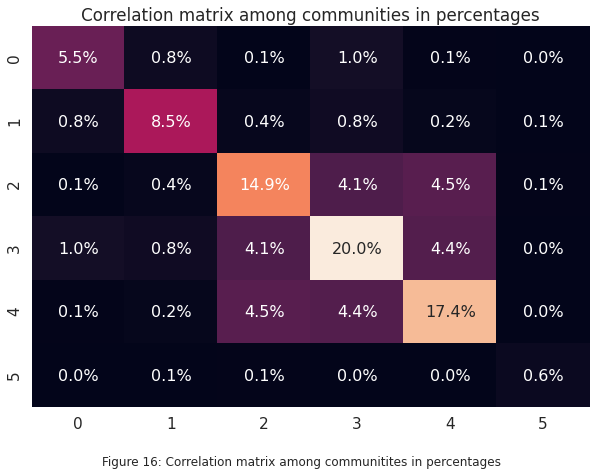

In [ ]:
#compute the normalized correlations and prepare the object to the visualisation
df_cm = pd.DataFrame((intercorrelations/sum(sum(intercorrelations))).round(decimals=4), range(len(communities_by_value)), range(len(communities_by_value))) 
plt.figure(figsize=(10,7))
plt.title("Correlation matrix among communities in percentages")
sn.heatmap(df_cm, annot=True, fmt=".1%", annot_kws={"size": 16}, cbar=False) # visualise the matrix
_=plt.figtext(0.5, 0.01, "Figure 16: Correlation matrix among communitites in percentages", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

  - **discuss the outcome:** The diagonal contains the nodes that go from community $i$ to community $i$, so the edges inside the same community. outside of the diagonal there are the edges among different communities. It can be seen from the figure above that the diagonal contains the higher values. This is in practise a better visualisation of the modularity parameter. the partition is meaningful because there are many intra-class edges and only few inter-class edges. It is interesting to see that communities 2, 3, 4 are high correlated. In the figures above it can be seen that these communities are those with similar number of nodes and also the most common tags are similar (for example, "indie" and "adventure"). As they have similar tags, it makes sense that they are in some way correlated. Finally, it is interesting to see that the last community is not so intra-correlated. This was also visible in the visualisation of the network, in which the nodes created agglomerates but had few edges one to each other. This result leads to the fact that Louvain method tends to prefer putting nodes together instead of overpartitioning the graph.

  ### Analysis step 11: correlation between the number of tags and the number of links
  - **explain what you're interested in:** now, as general analysis, we want to understand if there exists a correlation between the number of tags of the node and its number of links. It is possible that this relation exists because the way in which we create a link is based on a mathematical treshold and this is proportional to the number of tags, implicitly. In particular, there are two aspects to take into account. The first is that a game with few tags is more likely to create more links, because they are necessary less common tags, in absolute. On the other hand, if a node has more tags, it is more probable that some of them are in common with the other node. If the distribution of the tags over the nodes were constant, these two aspects should compensate. As seen before, this is not the case, and some correlation should appear.
  - **explain the tool:** the idea is to extract both the number of tags and the degree for each node, respectively having the dictionaries with `nx.get_node_attributes(GN,"tags")` and `G.degree()`. As the keys are the nodes, and the methods return them with the same order, it is enough to take the list of the values and we are sure that elements in the same positions refer to the same node. Then, a heatmap is built with all the pairs of values and it is visualised with the method `imshow`. Then, we will see that the result in this way doesn't take into account that the distribution of the number of nodes over the number of tags it is not costant and so we will do a normalization in order to be able to compare the data.
  - **apply the tool:**

In [ ]:
degree=dict(GN.degree()) #dictionary with nodes as keys and relative degrees as values
num_of_tags=nx.get_node_attributes(GN,"tags") #dictionary with nodes as keys and relative lists of tags as values
for id in num_of_tags: #for each node
  num_of_tags[id] = len(num_of_tags[id]) #save the number of tags

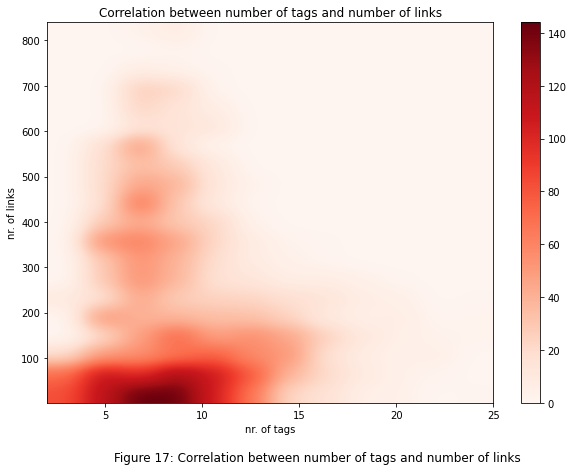

In [ ]:
heatmap, xedges, yedges = np.histogram2d(list(num_of_tags.values()), list(degree.values()), bins=[12, 20]) #build the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,7))
plt.clf()
plt.title("Correlation between number of tags and number of links")
plt.xlabel("nr. of tags")
plt.ylabel("nr. of links")
cor = plt.imshow(heatmap.T, extent=extent,cmap='Reds', interpolation='gaussian', origin='lower', aspect="auto")  #visualise the heatmap
plt.colorbar(cor)
_=plt.figtext(0.5, 0.01, "Figure 17: Correlation between number of tags and number of links", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [ ]:
count = Counter(num_of_tags.values())
plt.figure(figsize=(10,5))
_=plt.bar(count.keys(), count.values(), label="samples")
plt.xlabel("nr. of tags")
plt.ylabel("nr. of nodes")
plt.title("Number of nodes per number of tags")
plt.legend()
_=plt.figtext(0.5, 0.01, "Figure 18: Histogram of the number of nodes per number of tags", wrap=True, horizontalalignment='center', fontsize=12)

In [ ]:
for i in range(len(heatmap)):
  heatmap[i]=[ele/(count[2+2*i]+count[3+2*i]) for ele in heatmap[i]]

In [ ]:
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,7))
plt.clf()
plt.title("Normalized correlation between number of tags and number of links")
plt.xlabel("nr. of tags")
plt.ylabel("nr. of links")
cor = plt.imshow(heatmap.T, extent=extent,cmap='Reds', interpolation='gaussian', origin='lower', aspect="auto")  #visualise the heatmap
plt.colorbar(cor)
_=plt.figtext(0.5, 0.01, "Figure 19: Normalized correlation between number of tags and number of links", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

  - **discuss the outcome:** from Figure (17) it can be seen the heatmap of the number of links for nomber of tags. The figure is useful to visualise the effective distribution of the links but it is not so meaningful to undertand the actual correlation. In fact, the data are affected by the fact that the distribution of the number of nodes for the number of links is not constant, as it can be seen from Figure (18). In fact, there is a peak of nodes that have around 7 tags and for this reason there absolute amount of links for nodes that have seven tags is bigger than the others. For this reason, a second version of the heatmap is shown in Figure (19). From that figure, the normalized correlation (i.e. the number of links per tag divided by the number of nodes for that tag) is shown. It can be seen that both for very little amount of tags and very big amount of tags, there are many links. In general, however, the normalized number of links for number of tags is more or less constant all over the scale, and this means that there is not a strong correlation. This leads to the fact that the initial choice on how to create a link between edges was a good choice, as it doesn't favor a node by the number of tags.


#Sentiment Analysis Steps

### In order to continue with the sentiment analysis, open the "Sentiment_analysis" notebook in the same folder.

### Then the final conclusions are below.

# Discussion. Think critically about your creation

## Creation of the network and statistics

There are many things to discuss after exploring the statistics of this network.

First of all, we have to mention the technological difficulties we ran into. For example, Colab was not powerful enough to work with the complete network so we limited the analysis on a subset. The statistics shown at the beginning on the distributions of the tags make us believe that the subset is a representative subset, but we can not be certain. Another problem was the fact that the data of the users was not available for privacy reasons so it was not possible to link the games with information about the users (for example, to link to games if a user played both) but only with information about the game itself (i.e. tags).

Not being able to gather data on the users and build a network from that, a
simple network based on similarities between games was built. 
This led to the strange statistics (i.e. the degree distributions, the average path length...). In fact, the graph was not a scale-free network because there were no meaningful hubs or a proper "social" structure and on the other hand it was not random because a structure existed. 

The communities are the strength of the analysis. In fact, the modularity score is high and the correlation matrix shows that there is a good separation among different communities. In addition, also the most common tags showed that the communities are meaningful. 

Finally, through the heatmap, we showed that how we chose to create a link between two nodes was meaningfull as the links are not greatly affected by the number of tags that a node has, but only for the tags themselves. So the links were created only based on the actual similarity among games. It must be said that the system of the tags is not well managed by Steam and that the most descriptive tags are rarely used, preferring tags as "Steam Cloud" or "Steam Achievements", that all the games have.

To improve the project, all the games should be considered and not only a subset. We would find it very interesting to build a network with user data but unfortunately that data is not available. 

## Sentiment analysis

We wanted to explore if we could find similarities between the comments in the communites found in the network analysis. As we have 26 different genres, we expected the comments between genres to vary. We saw from part 2 that the comments between certain genres vary but not drasticly. As there are 26 genres we wanted to explore if we could split similar genre based games up to fewer clusters, communities, and analyze the comments in those clusters. As our analysis has shown, both the sentiment rate and the content of the comments do not vary between communities and no hypothesis can be made after the analysis. 

The analysis on the short description of the games on the other hand showed that the description of games within communites contain similarites and that similar words are used to descripe games within these communites. From that we can conclude that the games within the communites are similar in their description, and therefore similar types of games. 




# Contributions. Who did what?

We have contributed equally to the decision of the topic and of the network to be built. Then, we have splitted the work as follow:
- Adrien Cochard, s202234: I've done all the video  editing for the project handin A, using Premiere Pro to add meaningfull videos, sounds and transitions. I'm also the website guy: I was in charge of completely doing the website, from the development of the front pages to the building and hosting of it. I've used Gatsby, a powerfull Javascript Framework based on React to do that.
- Bergdís Arnardóttir, s202059. Worked on the text analysis, that is all work in the notebook "Sentiment_Analysis".
- Giovanni Grego, s202287: I worked on retrieving the data, on creating the network and on analysing it from the point of view of the statistics. In particular, I did the work covered by this notebook from the beginning to the "Analysis step 11: correlation between the number of tags and the number of links". In addition, I wrote the relative part of the notebook, so from the beginning to the "Analysis step 11: correlation between the number of tags and the number of links" as well as the discussion of that part ("Creation of the network and statistics").

These are the parts each student focused on, but all work was read over and modified by the others in the group.
 